# Modeling Coronavirus

Last updated 3/21/2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (9,6)
import numpy as np
import pandas as pd
import pyviral

## Set some constants

In [2]:
# United States population
N = 327e6

# United States birth rate per day - 12 per 1000 per year
Alpha = 12/1000/365

# United States death rate per day - 8 per 1000 per year
Mu = 8/1000/365

# Numerical integration step
dt = 0.001

## Get data from  Johns Hopkins

Source: https://github.com/CSSEGISandData/COVID-19

In [3]:
confirmed_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
recovered_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"


In [4]:
# Download and munge
confirmed = pd.read_csv(confirmed_csv)
recovered = pd.read_csv(recovered_csv)
deaths = pd.read_csv(deaths_csv)

In [5]:
drop_cols = ["Province/State", "Country/Region", "Lat", "Long"]
def munge_us(data):
    return (data[(data['Country/Region'] == 'US') & 
              ~data['Province/State'].str.contains(',').fillna(False) &
              ~data['Province/State'].str.contains('Princess').fillna(False)]
            .drop(drop_cols, axis=1).sum(axis=0))
day1 = 48
confirmed_us = munge_us(confirmed).iloc[day1:]
recovered_us = munge_us(recovered).iloc[day1:]
deaths_us = munge_us(deaths).iloc[day1:]

In [6]:
confirmed_us

3/10/20      892
3/11/20     1214
3/12/20     1596
3/13/20     2112
3/14/20     2660
3/15/20     3432
3/16/20     4565
3/17/20     6353
3/18/20     7715
3/19/20    13608
3/20/20    19028
3/21/20    25417
dtype: int64

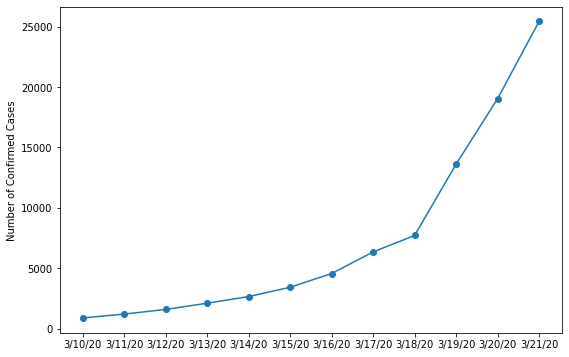

In [7]:
# Plot it
plt.plot(confirmed_us, 'o-')
plt.ylabel("Number of Confirmed Cases")
plt.show()

In [8]:
# Approximate the death rate.
death_rate = deaths_us[-1] / confirmed_us[-1]
death_rate

0.012078530117637801

In [9]:
days = len(confirmed_us) - 1

## Find the parameters of the SIR model that match the data

Assuming the confirmed cases represents the real number of cumulative infections. This is a big assumption because testing is very limited.

Also assuming a 10% recovery rate.

Ignore birth rate, death rate, and immunity loss.

In [10]:
# Cumulative cases the number of new infections per day.
# It's also the same as n - s.
# But we have to account for the fact that the differential equations use the 
# number of current infections.
# It's easiest to find this numerically.
t = days
I0 = confirmed_us.values[0]
gamma = 0.1
def solve_beta(I0, gamma, t, actual):
    def yield_diffs(betas):
        for betan in betas:
            S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
            yield np.abs(N - S[-1] - actual)
    betas = np.arange(0.2, 0.9, 0.05)
    diffs = np.array(list(yield_diffs(betas)))
    best = betas[np.argmin(diffs)]
    betas = np.arange(best - 0.05, best + 0.05, 0.001)
    diffs = np.array(list(yield_diffs(betas)))
    return betas[np.argmin(diffs)]
betan = solve_beta(confirmed_us.values[0], gamma, days, confirmed_us.values[-1])
betan

0.37800000000000006

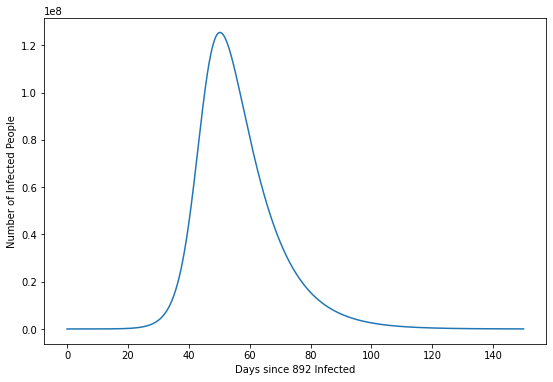

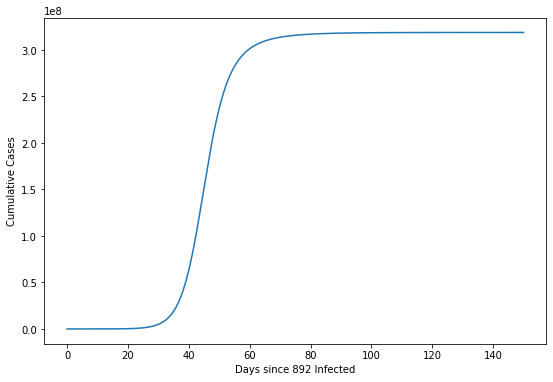

Infections peak at 125 million in 50 days.
A total of 318 million will be infected at some point.
There will be 3 million total deaths.


In [11]:
I0 = confirmed_us.values[0]
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
# The number of cumulative cases is the same as the number people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I)
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.show()

plt.plot(T, C)
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.show()
print("Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("There will be %i million total deaths." % (C[-1] / 1e6 * death_rate))

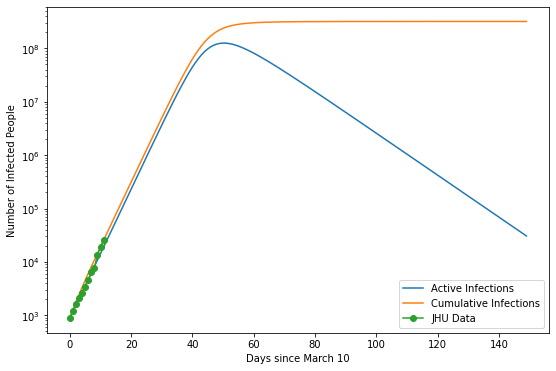

In [12]:
# Plotted on a log scale
daymap = T%1 == 0
plt.plot(T[daymap], I[daymap], label="Active Infections")
plt.plot(T[daymap], C[daymap], label="Cumulative Infections")
plt.plot(np.arange(len(confirmed_us)), confirmed_us.values, 'o-', label="JHU Data")
plt.xlabel("Days since March 10")
plt.ylabel("Number of Infected People")
plt.yscale('log')
plt.legend()
plt.show()

## What if the real number of infections is much larger than the confirmed number?

Because of lack of testing.

How much does this change beta? How does this change the dynamics?

In [13]:
confirmed_us.values

array([  892,  1214,  1596,  2112,  2660,  3432,  4565,  6353,  7715,
       13608, 19028, 25417])

In [14]:
# Define a new parameter, the testing rate.
# The number of known infections = tau * i
tau = 0.1 # Only 10% of the people who might be infected are getting tested.

In [15]:
# Now we want to match the cumulative known cases to the JHU data.
I0 = confirmed_us.values[0] / tau
gamma = 0.1
betan1 = solve_beta(confirmed_us.values[0] / tau, gamma, days, confirmed_us.values[-1] / tau)
I0, betan1

(8920.0, 0.37800000000000006)

In [16]:
# We get the same value for beta. Probably could have found this with algebra. 

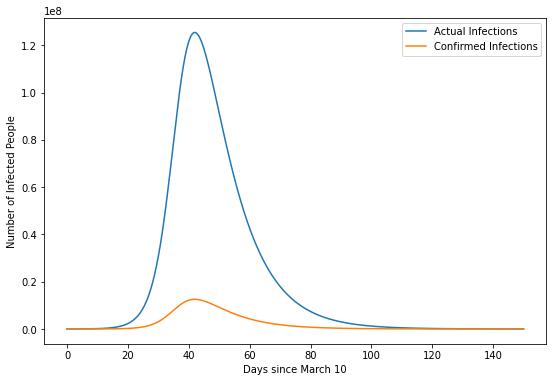

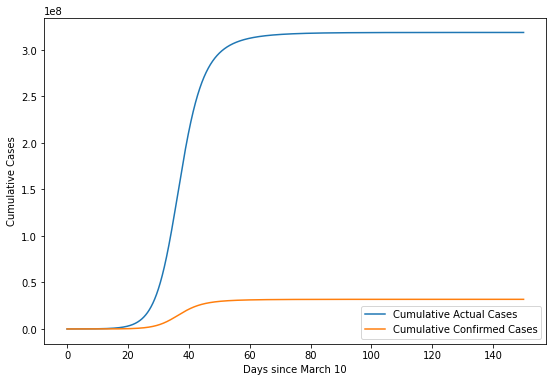

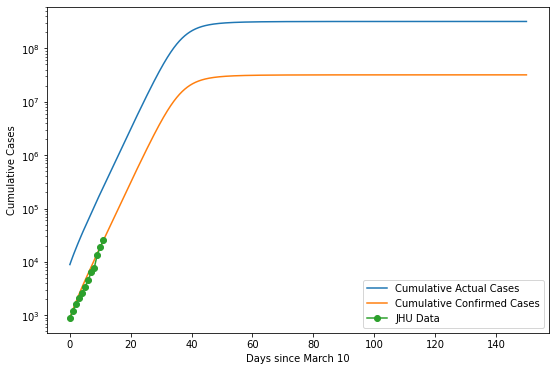

Confirmed Infections peak at 12 million in 41 days.
Actual Infections peak at 125 million in 41 days.
A total of 318 million will be infected at some point.
We'll only know about 31 million total cases if we don't improve testing.
There will be 385 thousand total deaths.


In [17]:
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
S, I, R = pyviral.run(N - I0, I0, beta=betan1 / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since March 10")
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.xlabel("Days since March 10")
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()


plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.plot(np.arange(len(confirmed_us)), confirmed_us.values, 'o-', label="JHU Data")
plt.xlabel("Days since March 10")
plt.ylabel("Cumulative Cases")
plt.yscale('log')
plt.legend()
plt.show()

print("Confirmed Infections peak at %i million in %i days." % (np.max(I) * tau / 1e6, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau * death_rate / 1e3))

## What if the recovery rate is higher?

If many of the undetected cases are mild, the average recovery rate could be a lot higher.

In [18]:
t = days
I0 = confirmed_us.values[0] / tau
gamma = 0.3
betan2 = solve_beta(confirmed_us.values[0] / tau, gamma, days, confirmed_us.values[-1] / tau)
betan2

0.533999999999998

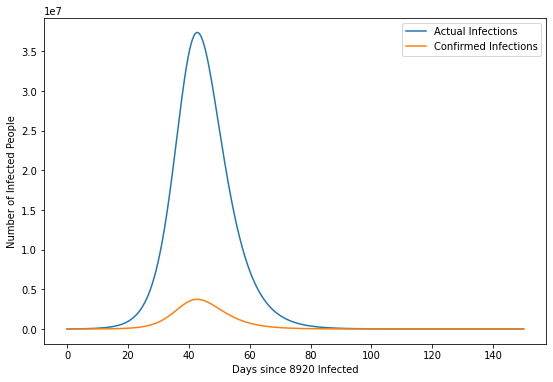

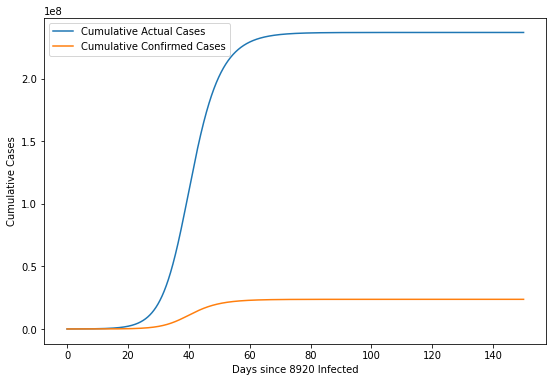

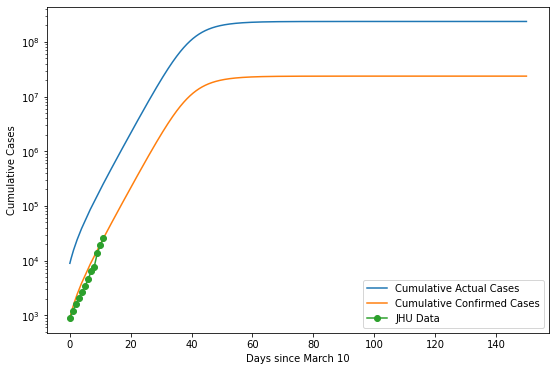

Confirmed Infections peak at 3 million in 42 days.
Actual Infections peak at 37 million in 42 days.
A total of 236 million will be infected at some point.
We'll only know about 23 million total cases if we don't improve testing.
There will be 286 thousand total deaths.


In [19]:
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.3
S, I, R = pyviral.run(N - I0, I0, beta=betan2 / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()

plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.plot(np.arange(len(confirmed_us)), confirmed_us.values, 'o-', label="JHU Data")
plt.xlabel("Days since March 10")
plt.ylabel("Cumulative Cases")
plt.yscale('log')
plt.legend()
plt.show()
print("Confirmed Infections peak at %i million in %i days." % (np.max(I) * tau / 1e6, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau  * death_rate/ 1e3))

## What if the missed cases is even more extreme?

tau = 0.01

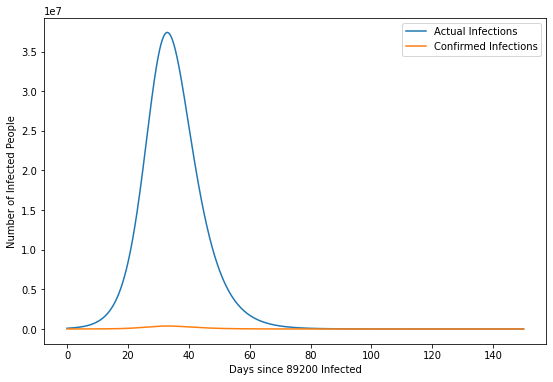

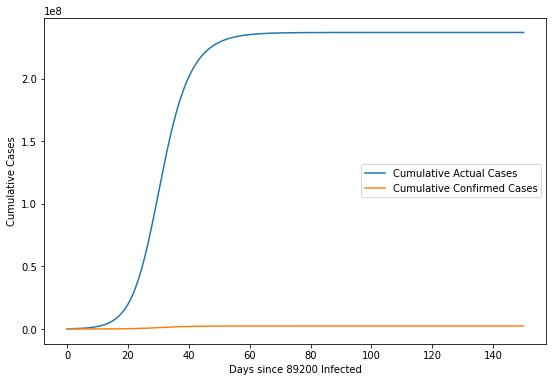

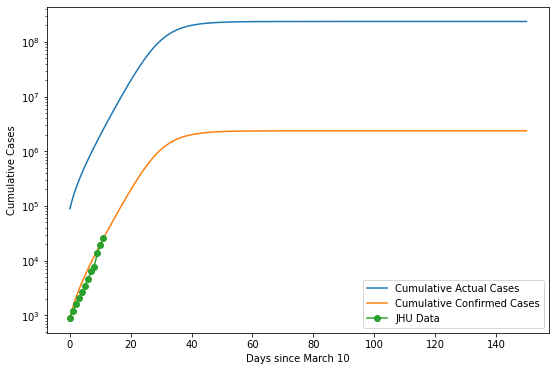

Confirmed Infections peak at 374 thousand in 32 days.
Actual Infections peak at 37 million in 32 days.
A total of 237 million will be infected at some point.
We'll only know about 2 million total cases if we don't improve testing.
There will be 28 thousand total deaths.


In [20]:
tau = 0.01
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.3
S, I, R = pyviral.run(N - I0, I0, beta=betan2 / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()

plt.plot(T, C, label="Cumulative Actual Cases")
plt.plot(T, C * tau, label="Cumulative Confirmed Cases")
plt.plot(np.arange(len(confirmed_us)), confirmed_us.values, 'o-', label="JHU Data")
plt.xlabel("Days since March 10")
plt.ylabel("Cumulative Cases")
plt.yscale('log')
plt.legend()
plt.show()
print("Confirmed Infections peak at %i thousand in %i days." % (np.max(I) * tau / 1e3, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau  * death_rate / 1e3))

# Comparing different levels of testing.

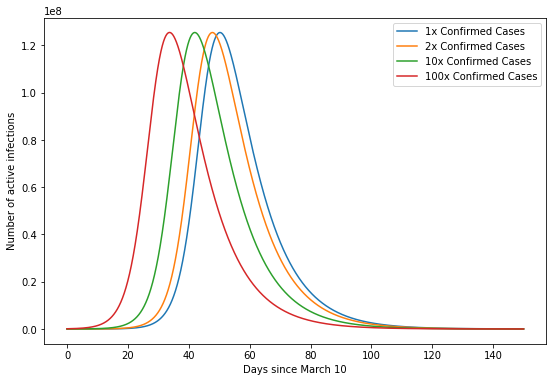

In [21]:
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
for tau in [1, .5, .1, .01]:
    I0 = confirmed_us.values[0] / tau
    S0 = N - I0
    S, I, R = pyviral.run(N - I0, I0, beta=betan1 / N, gamma=gamma, t=t, dt=dt)
    plt.plot(T, I, label="%ix Confirmed Cases" % (1/tau))
plt.legend()
plt.xlabel("Days since March 10")
plt.ylabel("Number of active infections")
plt.show()

## Comparing recovery rates

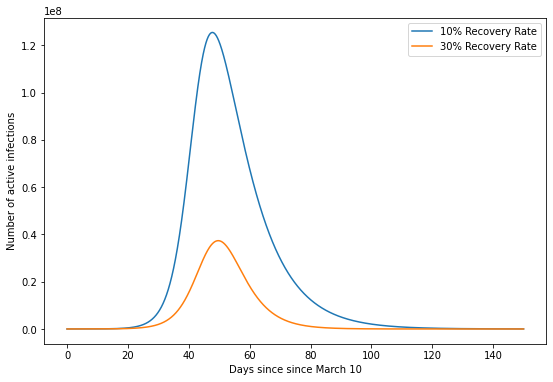

In [22]:
tau = 0.5
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
S, I, R = pyviral.run(N - I0, I0, beta=betan1 / N, gamma=gamma, t=t, dt=dt)
plt.plot(T, I, label="10% Recovery Rate")
gamma = 0.3
S, I, R = pyviral.run(N - I0, I0, beta=betan2 / N, gamma=gamma, t=t, dt=dt)
plt.plot(T, I, label="30% Recovery Rate")
plt.xlabel("Days since since March 10")
plt.ylabel("Number of active infections")
plt.legend()
plt.show()